# Retail Product Recommender Engine
**By [Czarina Luna](https://czarinaluna.com)**

### Contents
* [I. Overview](#I.-Overview)
* [II. Business Problem](#II.-Business-Problem)
* [III. Data Understanding](#III.-Data-Understanding)
* [IV. Recommendation Systems](#IV.-Recommendation-Systems)
* [V. Results and Recommendations](#V.-Results-and-Recommendations)
* [VI. Further Research](#VI.-Further-Research)

## I. Overview

## II. Business Problem

Write here.

## III. Data Understanding

Write here.

In [1]:
import pandas as pd

raw_data = pd.read_csv('data/data.csv')

# Quick look at the data structure
raw_data.head(2)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"


Missing values:

In [2]:
raw_data.isna().sum()

fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text          62
body type         14637
review_summary      345
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

Target variable:

In [3]:
raw_data['rating'].value_counts()

10.0    124537
8.0      53391
6.0      10697
4.0       2791
2.0       1046
Name: rating, dtype: int64

**Data cleaning** steps in the function `preprocess_data`:
- Drop missing values for `rating`  and change the scale for from 2-10 to 1-5.
- Remove the units of measurement for `weight` and `height` to only keep the numerical values.
- Impute missing values with the median for `age` and a few other features and with mode for `rented_for`.
- Impute missing value for `bust_size` with the median value by `body_type` and vice versa.
- Count the number of words in `text_summary` and `text_review` together to create new feature `length`.
- Create new features `review_month`, `review_season`, and `review_year` based on `review_date`.

In [4]:
import numpy as np

def convert_height(x):
    '''
    Converts height from string format as feet and inches to integer in inches.
    '''
    height = [int(i) for i in x.replace('\'', '').replace('"', '').split()]
    return height[0]*12 + height[1]

def preprocess_data(df):
    '''
    Cleans the dataframe using imputation and feature engineering.
    '''
    df.columns = df.columns.str.replace(' ', '_')
    df = df.dropna(subset=['rating'])
    
    df['weight'] = df['weight'].str.replace('lbs', '')
    df['rating'] = df['rating']/2
    df['height'] = df['height'].apply(lambda x: convert_height(x) if pd.notnull(x) else x)
    
    to_num = ['rating', 'weight', 'age']
    df[to_num] = df[to_num].apply(pd.to_numeric, errors='coerce')
    
    for col in ['height', 'age']:
        df[col] = df[col].fillna(df[col].median())
        
    weight_map = dict(df.groupby('height')['weight'].median())
    df['weight'] = df['weight'].fillna(df['height'].map(weight_map))
    
    for col in ['review_text', 'review_summary']:
        df[col] = df[col].replace('-', np.nan)
    df['review'] = df['review_summary'] + ' ' + df['review_text']
    df['review'] = df['review'].fillna('')
    df['review_length'] = df['review_text'].fillna('').apply(lambda x: len(x.split()))
        
    age_limit = (df['age'] > 60) | (df['age'] < 13)
    df['age'] = np.where(age_limit==True, df['age'].median(), df['age'])
    
    for col in ['bust_size', 'body_type']:
        to_map = dict(df.groupby('size')[col].last())
        df[col] = df[col].fillna(df['size'].map(to_map))
    
    df['rented_for'] = df['rented_for'].fillna(df['rented_for'].value_counts().index[0])
    
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['review_month'] = pd.DatetimeIndex(df['review_date']).month
    df['review_season'] = pd.cut(df['review_month'].replace(12, 0), [0, 3, 6, 9, 11], include_lowest=True, labels=['Winter', 'Spring', 'Summer', 'Fall'])
    df['review_year'] = pd.DatetimeIndex(df['review_date']).year
    return df

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Create new dataframe for processed data
data = preprocess_data(raw_data)

In [6]:
pd.options.display.float_format = '{:.2f}'.format

# Summary statistics for numerical features
data.drop(columns=['user_id', 'item_id']).describe().T

,count,mean,std,min,25%,50%,75%,max
weight,192462.00,136.92,20.43,50.00,125.00,135.00,145.00,300.00
rating,192462.00,4.55,0.72,1.00,4.00,5.00,5.00,5.00
height,192462.00,65.31,2.66,54.00,63.00,65.00,67.00,78.00
size,192462.00,12.25,8.50,0.00,8.00,12.00,16.00,58.00
age,192462.00,33.60,7.39,14.00,29.00,32.00,37.00,60.00
review_length,192462.00,58.40,43.04,0.00,27.00,50.00,79.00,398.00
review_month,192462.00,6.85,3.38,1.00,4.00,7.00,10.00,12.00
review_year,192462.00,2015.69,1.33,2010.00,2015.00,2016.00,2017.00,2018.00


### Data Visualization
***

Write about user data.

In [7]:
def create_user_data(df):
    '''
    Write here.
    '''
    user_df = pd.DataFrame(df.groupby('user_id').count().reset_index()['user_id'])
    
    for col in df.columns:
        if col in ['bust_size', 'weight']:
            feature = df.sort_values('review_date', ascending=False).groupby('user_id')[col].first()
            user_df = user_df.merge(feature, on='user_id')
        if col == 'item_id':
            feature = df.groupby(df['user_id']).count()[col]
            user_df = user_df.merge(feature, on='user_id')
        if col == 'rating':
            feature = df.groupby(df['user_id']).mean()[col]
            user_df = user_df.merge(feature, on='user_id')
        if col in ['body_type', 'height', 'size', 'age']:
            feature = df.sort_values('review_date', ascending=False).groupby('user_id')[col].first()
            user_df = user_df.merge(feature, on='user_id')
        if col == 'review_length':
            feature = df.groupby(df['user_id']).mean()[col]
            user_df = user_df.merge(feature, on='user_id')
        if col in ['review_month', 'review_season']:
            feature = df.sort_values('review_date', ascending=False).groupby('user_id')[col].agg(lambda x: x.value_counts().index[0])
            user_df = user_df.merge(feature, on='user_id')
        if col in ['rented_for', 'category']:
            feature = df.sort_values('review_date', ascending=False).groupby('user_id')[col].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)
            user_df = user_df.merge(feature, on='user_id')
        else:
            continue
        
    for col in ['rented_for', 'category']:
        feature = df.groupby('user_id')[col].apply(set).apply(lambda x: list(x))
        user_df = user_df.merge(feature, on='user_id')
    
    user_df.columns = ['user_id', 'bust_size', 'rating_count', 'weight', 'rating_average', 'rented_for_top', 
                       'body_type', 'category_top', 'height', 'size', 'age', 'review_length_average', 
                       'review_month_top', 'review_season_top', 'rented_for_all', 'category_all']
    
    return user_df

In [8]:
user_data = create_user_data(data)
user_data.head(2)

,user_id,bust_size,rating_count,weight,rating_average,rented_for_top,body_type,category_top,height,size,age,review_length_average,review_month_top,review_season_top,rented_for_all,category_all
0,9,32c,2,145.00,5.00,formal affair,pear,dress,66.00,8,32.00,121.50,3,Winter,"[wedding, formal affair]","[gown, dress]"
1,25,34ddd/e,1,130.00,5.00,party,full bust,legging,67.00,8,40.00,14.00,12,Winter,[party],[legging]


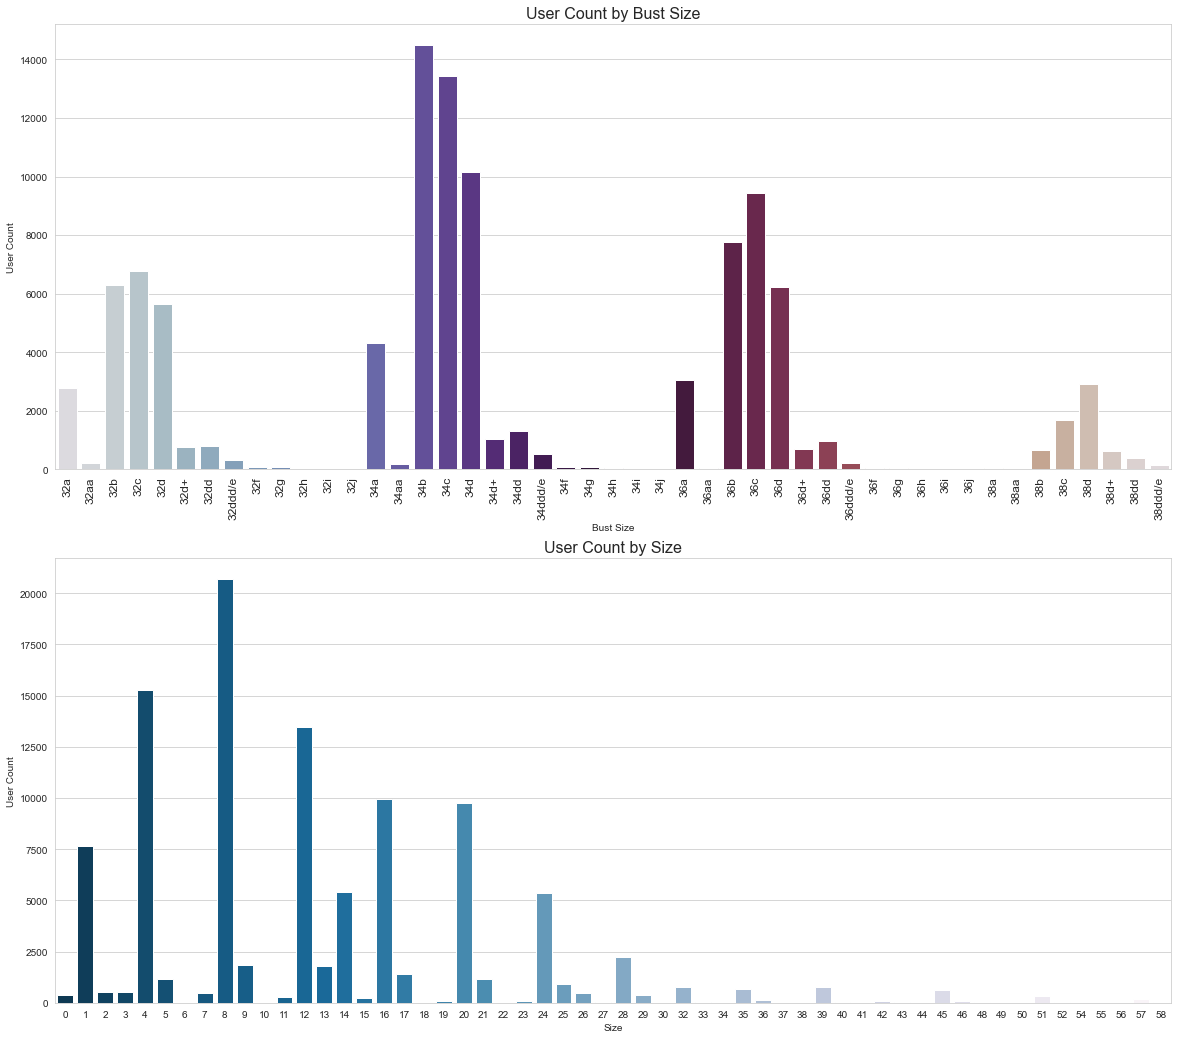

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

bust_size_sorted_data = user_data.loc[(user_data['bust_size']>='32a') & (user_data['bust_size']<='38ddd/e')].sort_values('bust_size')

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=2, figsize=(20, 18))

sns.countplot(x='bust_size', data=bust_size_sorted_data, palette='twilight', ax=axes[0])
sns.countplot(x='size', data=user_data, palette='PuBu_r', ax=axes[1])

axes[0].set_title('User Count by Bust Size', fontsize=16)
axes[0].set_xlabel('Bust Size')
axes[0].set_ylabel('User Count')
axes[0].set_xticklabels(bust_size_sorted_data['bust_size'].unique(), rotation=90, fontsize=12)

axes[1].set_title('User Count by Size', fontsize=16)
axes[1].set_xlabel('Size')
axes[1].set_ylabel('User Count')

plt.savefig('data/images/fig0.png', dpi=200, transparent=True) 
plt.show()

Write here.

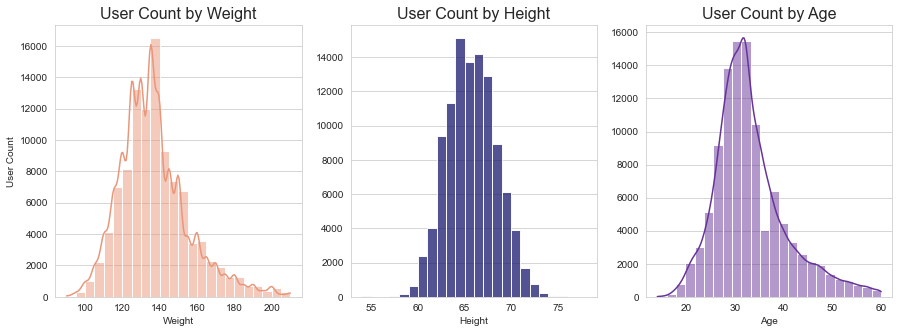

In [10]:
weight_data = user_data.loc[(user_data['weight']>=90) & (user_data['weight']<=210)]

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

sns.histplot(x='weight', data=weight_data, bins=24, color='darksalmon', kde=True, ax=axes[0])
sns.histplot(x='height', data=user_data, bins=24, color='midnightblue', ax=axes[1])
sns.histplot(x='age', data=user_data, bins=24, color='rebeccapurple', kde=True, ax=axes[2])

axes[0].set_title('User Count by Weight', fontsize=16)
axes[0].set_xlabel('Weight')
axes[0].set_ylabel('User Count')
axes[0].grid(axis='x')

axes[1].set_title('User Count by Height', fontsize=16)
axes[1].set_xlabel('Height')
axes[1].set(ylabel=None)
axes[1].grid(axis='x')

axes[2].set_title('User Count by Age', fontsize=16)
axes[2].set_xlabel('Age')
axes[2].set(ylabel=None)
axes[2].grid(axis='x')

plt.savefig('data/images/fig1.png', dpi=200, transparent=True) 
plt.show()

Write here.

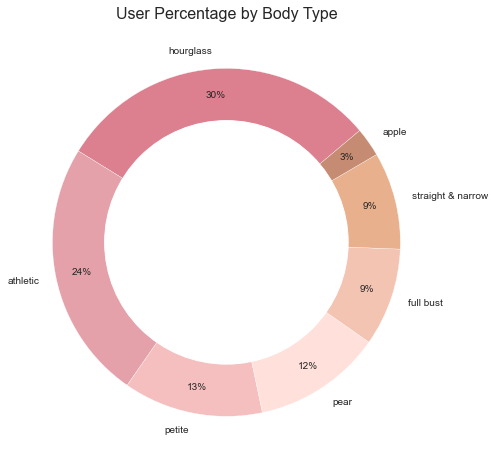

In [11]:
body_type_values = user_data['body_type'].value_counts().values
body_type_names = user_data['body_type'].value_counts().index

body_type_circle = plt.Circle((0,0), 0.7, color='white')

plt.style.use('seaborn')
plt.figure(figsize=(8,8))
colors = ['#DC7F8E', '#E5A1AA', '#F4BFBE', '#FFE0DA', '#F4C4B2', '#E8B08D', '#C68C73']

plt.pie(body_type_values, labels=body_type_names, colors=colors, autopct='%1.0f%%', startangle=40, pctdistance=0.85)
p = plt.gcf()
p.gca().add_artist(body_type_circle)

plt.title('User Percentage by Body Type', fontsize=16)
plt.savefig('data/images/fig2.png', dpi=200, transparent=True) 
plt.show()

Write here.

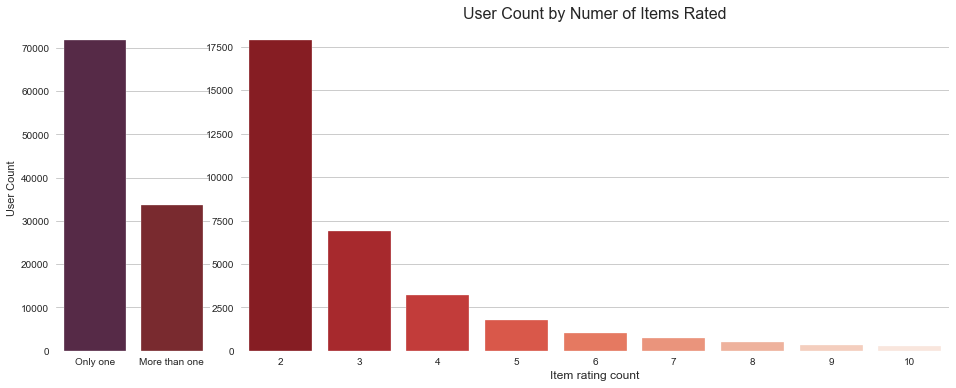

In [12]:
item_count_data = user_data.copy()
item_count_data['rating_count'] = item_count_data['rating_count'].apply(lambda x: 'Only one' if x==1 else 'More than one')

rating_count_data = user_data.loc[(user_data['rating_count']>=2) & (user_data['rating_count']<=10)]

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

axes[0] = plt.subplot2grid((1, 5), (0, 0))
axes[1] = plt.subplot2grid((1, 5), (0, 1), colspan=4)

sns.countplot(x='rating_count', data=item_count_data, palette=['#5d2349', '#861d23'], order=['Only one', 'More than one'], ax=axes[0])
sns.countplot(x='rating_count', data=rating_count_data, palette='Reds_r', ax=axes[1])

axes[0].set(xlabel=None)
axes[0].set_ylabel('User Count')

axes[1].set_title('User Count by Numer of Items Rated', fontsize=16)
axes[1].set_xlabel('Item rating count', fontsize=12)
axes[1].set(ylabel=None)

plt.savefig('data/images/fig3.png', dpi=200, transparent=True) 
plt.show()

Write here.

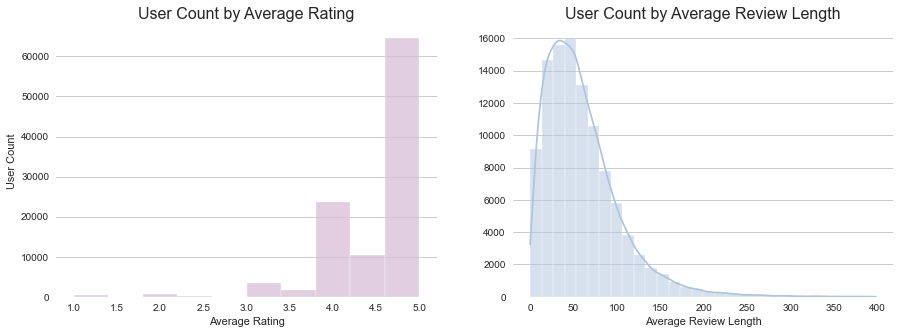

In [13]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.histplot(x='rating_average', data=user_data, bins=10, color='thistle', ax=axes[0])
sns.histplot(x='review_length_average', data=user_data, bins=30, color='lightsteelblue', kde=True, ax=axes[1])

axes[0].set_title('User Count by Average Rating', fontsize=16)
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('User Count')
axes[0].grid(axis='x')

axes[1].set_title('User Count by Average Review Length', fontsize=16)
axes[1].set_xlabel('Average Review Length')
axes[1].set(ylabel=None)
axes[1].grid(axis='x')

plt.savefig('data/images/fig4.png', dpi=200, transparent=True) 
plt.show()

Write here.

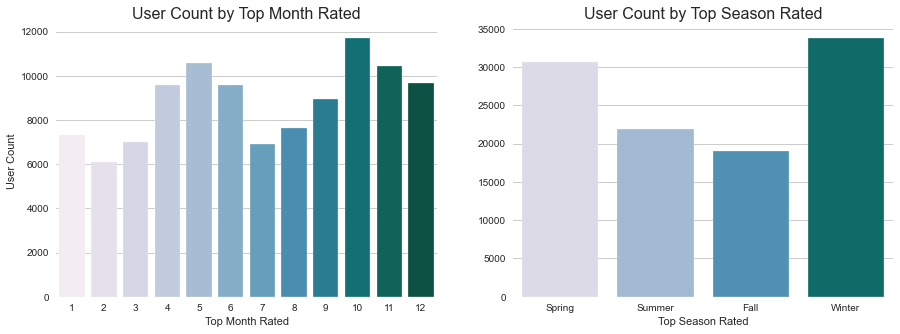

In [14]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.countplot(x='review_month_top', data=user_data, palette='PuBuGn', ax=axes[0])
sns.countplot(x='review_season_top', data=user_data, order=['Spring', 'Summer', 'Fall', 'Winter'], palette='PuBuGn', ax=axes[1])

axes[0].set_title('User Count by Top Month Rated', fontsize=16)
axes[0].set_xlabel('Top Month Rated')
axes[0].set_ylabel('User Count')

axes[1].set_title('User Count by Top Season Rated', fontsize=16)
axes[1].set_xlabel('Top Season Rated')
axes[1].set(ylabel=None)

plt.savefig('data/images/fig5.png', dpi=200, transparent=True) 
plt.show()

Write here.

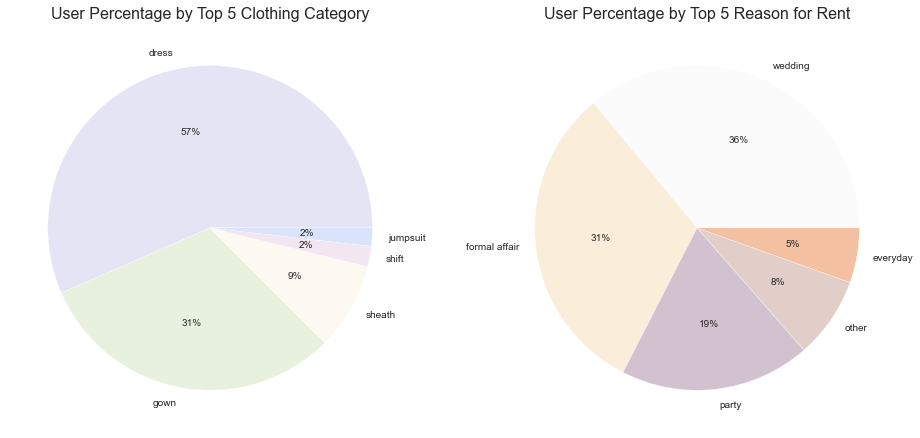

In [15]:
category_top_data = user_data.loc[user_data['category_top'].isin(user_data['category_top'].value_counts()[:5].index.tolist())]
rented_for_top_data = user_data.loc[user_data['rented_for_top'].isin(user_data['rented_for_top'].value_counts()[:5].index.tolist())]

category_top_values = (category_top_data['category_top'].value_counts(normalize=True).values*100).tolist()
category_top_labels = category_top_data['category_top'].value_counts().index.tolist()
category_colors = ['#E5E4F4', '#E8F1DE', '#FDF9F0', '#F2E6F0', '#D9E4FB']

rented_for_top_values = (rented_for_top_data['rented_for_top'].value_counts(normalize=True).values*100).tolist()
rented_for_top_labels = rented_for_top_data['rented_for_top'].value_counts().index.tolist()
rented_for_colors = ['#FBFBFB', '#FAEDDA', '#D2C1CE', '#E1CEC9', '#F3C0A1']

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

axes[0].pie(category_top_values, labels=category_top_labels, colors=category_colors, autopct='%.0f%%')
axes[1].pie(rented_for_top_values, labels=rented_for_top_labels, colors=rented_for_colors, autopct='%.0f%%')

axes[0].set_title('User Percentage by Top 5 Clothing Category', fontsize=16)
axes[1].set_title('User Percentage by Top 5 Reason for Rent', fontsize=16)

plt.savefig('data/images/fig6.png', dpi=200, transparent=True) 
plt.show()

Write about above graph.

Write about **item data**.

In [16]:
def create_item_data(df):
    '''
    Write here.
    '''
    item_df = pd.DataFrame(df.groupby('item_id').count().reset_index()['item_id'])
    
    for col in df.columns:
        if col == 'fit':
            feature_small = df.loc[df[col]=='small'].groupby('item_id').count()[col]
            feature_fit = df.loc[df[col]=='fit'].groupby('item_id').count()[col]
            feature_large = df.loc[df[col]=='large'].groupby('item_id').count()[col]
            for idx, feature in enumerate([feature_small, feature_fit, feature_large]):
                item_df = item_df.join(feature, on='item_id', rsuffix=idx).fillna(0)
        if col == 'user_id':
            feature = df.groupby(df['item_id']).count()[col]
            item_df = item_df.merge(feature, on='item_id')
        if col in ['bust_size', 'body_type']:
            feature = df.sort_values('review_date', ascending=False).groupby('item_id')[col].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)
            item_df = item_df.merge(feature, on='item_id')
        if col in ['weight', 'height', 'size', 'age']:
            feature_mean = df.groupby(df['item_id']).mean()[col]
            feature_median = df.groupby(df['item_id']).median()[col]
            for feature in [feature_mean, feature_median]:
                item_df = item_df.merge(feature, on='item_id')
        if col in ['rating', 'review_length']:
            feature = df.groupby(df['item_id']).mean()[col]
            item_df = item_df.merge(feature, on='item_id')
        if col in ['rented_for', 'category']:
            feature = df.sort_values('review_date', ascending=False).groupby('item_id')[col].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)
            item_df = item_df.merge(feature, on='item_id')
        if col == 'rented_for':
            feature = df.groupby('item_id')[col].apply(set).apply(lambda x: list(x))
            item_df = item_df.merge(feature, on='item_id')
        if col in ['review_month', 'review_season']:
            feature = df.sort_values('review_date', ascending=False).groupby('item_id')[col].agg(lambda x: x.value_counts().index[0])
            item_df = item_df.merge(feature, on='item_id')
        else:
            continue
            
    item_df.columns = ['item_id', 'fit_small', 'fit', 'fit_large', 'user_count', 'bust_size_top', 'weight_mean', 
                       'weight_median', 'rating_average', 'rented_for_top', 'rented_for_all', 'body_type_top', 
                       'category_top', 'height_mean', 'height_median', 'size_mean', 'size_median', 'age_mean', 
                       'age_median', 'review_length_average', 'review_month_top', 'review_season_top']
    
    return item_df

In [17]:
item_data = create_item_data(data)
item_data.head(2)

,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,...,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top
0,123373,73.00,566.00,47.00,686,36d,140.67,135.00,4.40,formal affair,...,gown,65.39,65.00,15.12,13.00,34.36,33.00,66.08,12,Winter
1,123793,65.00,1497.00,152.00,1714,34b,132.98,130.00,4.77,formal affair,...,gown,65.06,65.00,9.72,8.00,31.31,31.00,74.41,5,Winter


### Time Series Analysis
***
Write here.

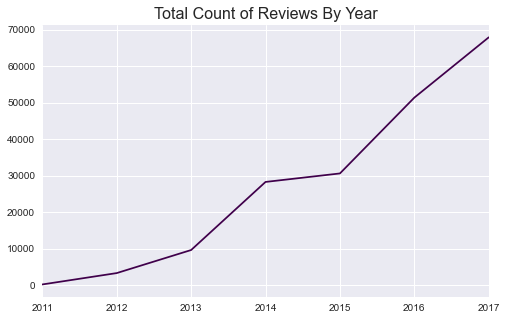

In [18]:
plt.style.use('seaborn')

time_series_data = data.sort_values('review_date').set_index('review_date', drop=True).drop('2010-11-03')

yearly_data = time_series_data.resample('Y').count()
yearly_data = yearly_data.drop(yearly_data.index[-1])
yearly_data['rating'].plot(figsize=(8,5), colormap='PRGn', xlabel='')

plt.title('Total Count of Reviews By Year', fontsize=16)
plt.savefig('data/images/fig7.png', dpi=200, transparent=True)
plt.show()

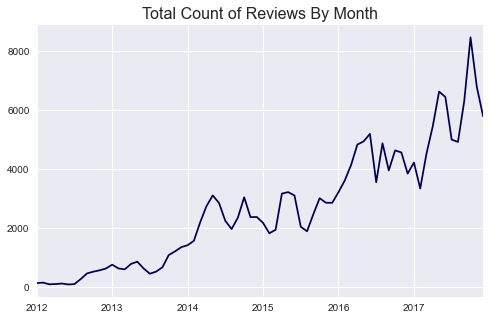

In [19]:
monthly_data = time_series_data[~(time_series_data['review_year']==2011)].resample('MS').count()
monthly_data = monthly_data.drop(monthly_data.index[-1])
monthly_data['rating'].plot(figsize=(8,5), colormap='seismic', xlabel='')

plt.title('Total Count of Reviews By Month', fontsize=16)
plt.savefig('data/images/fig8.png', dpi=200, transparent=True)
plt.show()

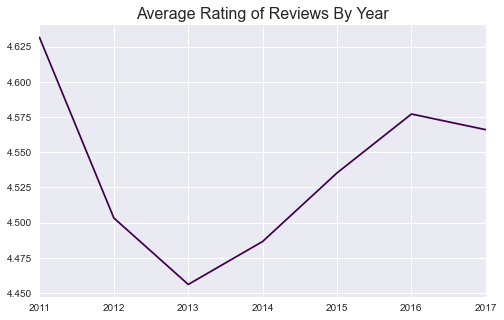

In [20]:
yearly_data = time_series_data.resample('Y').mean()
yearly_data = yearly_data.drop(yearly_data.index[-1])
yearly_data['rating'].plot(figsize=(8,5), colormap='PRGn', xlabel='')

plt.title('Average Rating of Reviews By Year', fontsize=16)
plt.savefig('data/images/fig9.png', dpi=200, transparent=True)
plt.show()

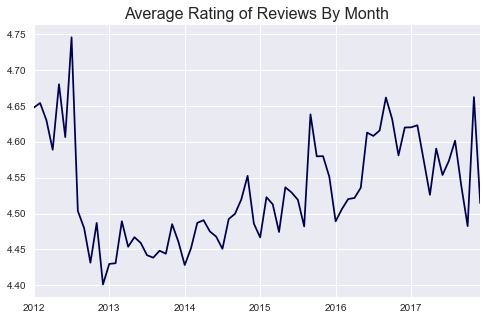

In [21]:
monthly_data = time_series_data[~(time_series_data['review_year']==2011)].resample('MS').mean()
monthly_data = monthly_data.drop(monthly_data.index[-1])
monthly_data['rating'].plot(figsize=(8,5), colormap='seismic', xlabel='')

plt.title('Average Rating of Reviews By Month', fontsize=16)
plt.savefig('data/images/fig10.png', dpi=200, transparent=True)
plt.show()

### Natural Language Processing

## IV. Data Methodology

Write here.

### Popularity Recommendation

##### Bayesian Average

$$W = \left(\frac{v}{v + m} \right)R + \left(\frac{m}{v + m} \right)C$$
where:

$W$ = Weighted rating <br>
$v$ = Number of ratings for the item <br>
$m$ = Minimum number of ratings required to be listed on top chart <br>
$R$ = Average rating of the item <br>
$C$ = Mean rating across the entire data

In [22]:
m = item_data['user_count'].quantile(0.9)
C = item_data['rating_average'].mean()

def weighted_rating(x, m=m, C=C):
    '''
    Calculates weighted rating based on Bayesian Average
    '''
    v = x['user_count']
    R = x['rating_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

def popular_recommendation(df=data, n=10):
    '''
    Write here.
    '''
    item_df = create_item_data(df)
    
    top_item_ratings = item_df.loc[(item_df['user_count']>=m)]
    top_item_ratings['score'] = top_item_ratings.apply(weighted_rating, axis=1)
    top_item_ratings = top_item_ratings.sort_values('score', ascending=False)
    
    return top_item_ratings.head(n)

In [23]:
pd.set_option('display.max_columns', 30)

top10_overall = popular_recommendation()
top10_overall

,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top,score
1948,1064397,12.00,257.00,15.00,284,34b,129.45,130.00,4.89,wedding,"[other, wedding, date, formal affair, party]",athletic,gown,64.81,65.00,8.14,8.00,28.65,28.00,60.74,10,Winter,4.82
1223,709832,30.00,151.00,9.00,190,34b,134.62,135.00,4.86,formal affair,"[other, date, wedding, formal affair, party]",hourglass,gown,65.11,65.00,12.14,12.00,33.95,32.00,72.49,3,Winter,4.77
2260,1213427,27.00,270.00,11.00,308,34b,132.22,130.00,4.82,wedding,"[other, wedding, date, formal affair, vacation...",athletic,gown,66.23,66.00,9.27,8.00,29.32,29.00,61.10,4,Spring,4.77
1608,903647,13.00,126.00,4.00,143,34b,140.04,138.00,4.88,formal affair,"[other, wedding, date, formal affair, party]",athletic,gown,65.94,66.00,12.67,12.00,34.43,32.00,60.87,10,Winter,4.76
2599,1378631,20.00,302.00,8.00,330,34b,139.89,135.00,4.81,wedding,"[other, wedding, date, formal affair, vacation...",hourglass,maxi,65.93,66.00,12.42,11.00,32.98,32.00,65.14,6,Spring,4.76
1,123793,65.00,1497.00,152.00,1714,34b,132.98,130.00,4.77,formal affair,"[other, wedding, date, work, formal affair, pa...",hourglass,gown,65.06,65.00,9.72,8.00,31.31,31.00,74.41,5,Winter,4.76
1812,1003076,5.00,122.00,5.00,132,34b,137.98,135.00,4.89,wedding,"[other, wedding, date, formal affair, vacation...",athletic,dress,65.96,66.00,11.55,12.00,32.80,32.00,55.21,10,Winter,4.76
2201,1186923,9.00,91.00,3.00,103,34c,137.48,135.00,4.92,party,"[other, date, wedding, formal affair, vacation...",hourglass,dress,65.33,65.00,13.53,14.00,30.33,30.00,65.70,11,Winter,4.76
2351,1260666,25.00,126.00,3.00,154,34b,130.13,130.00,4.84,party,"[other, date, wedding, formal affair, vacation...",hourglass,dress,64.82,65.00,10.66,8.00,32.77,32.50,54.05,7,Spring,4.74
1236,714374,23.00,112.00,2.00,137,34b,133.23,132.00,4.85,wedding,"[other, wedding, date, work, formal affair, pa...",athletic,dress,65.83,66.00,10.18,8.00,31.49,30.00,55.97,10,Fall,4.74


In [24]:
column_list = []
operator_list = []
condition_list = []

def append_condition(column, operation, condition):
    '''
    Appends a filter to column, operator, and condition lists.
    ''' 
    column_list.append(column)
    operator_list.append(operation)
    condition_list.append(condition)

def filter_popular_recommendation(df=data, n=10, bust_size=None, weight=None, rating=None, rented_for=None, 
                                  body_type=None, category=None, height=None, size=None, age=None, 
                                  review_month=None, review_season=None, review_year=None):
    '''
    Write here.
    '''
    if bust_size:
        append_condition('bust_size', '==', bust_size)
    if weight:
        append_condition('weight', '>=', weight-10)
        append_condition('weight', '<=', weight+10)
    if rented_for:
        append_condition('rented_for', '==', rented_for)
    if body_type:
        append_condition('body_type', '==', body_type)
    if category:
        append_condition('category', '==', category)
    if height:
        append_condition('height', '>=', height-2)
        append_condition('height', '>=', height+2)
    if size:
        append_condition('size', '==', size)
    if age:
        append_condition('age', '>=', age-4)
        append_condition('age', '<=', age+4)
    if review_month:
        append_condition('review_month', '==', review_month)
    if review_season:
        append_condition('review_season', '==', review_season)
    if review_year:
        append_condition('review_year', '==', review_year)
    
    condition = ' & '.join(f'{col} {op} {repr(cond)}' for col, op, cond in zip(column_list, operator_list, condition_list))
    filtered_df = df.query(condition)
    
    return popular_recommendation(filtered_df, n)

def reset_condition():
    '''
    Reinitializes lists for query for filtered popularity recommender.
    '''
    column_list = []
    operator_list = []
    condition_list = []
    return column_list, operator_list, condition_list

In [25]:
top10_dress = filter_popular_recommendation(category='dress')
column_list, operator_list, condition_list = reset_condition()
top10_dress

,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top,score
1223,1003076,5.00,122.00,5.00,132,34b,137.98,135.00,4.89,wedding,"[other, wedding, date, formal affair, vacation...",athletic,dress,65.96,66.00,11.55,12.00,32.80,32.00,55.21,10,Winter,4.76
1483,1186923,9.00,91.00,3.00,103,34c,137.48,135.00,4.92,party,"[other, date, wedding, formal affair, vacation...",hourglass,dress,65.33,65.00,13.53,14.00,30.33,30.00,65.70,11,Winter,4.76
1584,1260666,25.00,126.00,3.00,154,34b,130.13,130.00,4.84,party,"[other, date, wedding, formal affair, vacation...",hourglass,dress,64.82,65.00,10.66,8.00,32.77,32.50,54.05,7,Spring,4.74
832,714374,23.00,112.00,2.00,137,34b,133.23,132.00,4.85,wedding,"[other, wedding, date, work, formal affair, pa...",athletic,dress,65.83,66.00,10.18,8.00,31.49,30.00,55.97,10,Fall,4.74
847,724319,5.00,99.00,14.00,118,32d,134.67,135.00,4.86,wedding,"[other, wedding, date, work, formal affair, pa...",hourglass,dress,65.27,65.00,9.83,8.00,33.51,33.00,51.08,10,Summer,4.73
1378,1106101,2.00,111.00,27.00,140,36b,142.86,140.00,4.84,wedding,"[other, wedding, date, formal affair, vacation...",hourglass,dress,65.81,66.00,11.57,14.00,31.01,30.00,48.90,11,Summer,4.73
154,241461,10.00,227.00,4.00,241,34d,141.32,135.00,4.78,wedding,"[other, wedding, date, formal affair, vacation...",hourglass,dress,66.10,66.00,14.15,12.00,31.70,30.00,67.82,6,Spring,4.72
2540,1940985,14.00,99.00,1.00,114,34d,139.75,138.00,4.83,wedding,"[other, wedding, date, work, formal affair, pa...",hourglass,dress,65.60,66.00,12.93,14.00,34.98,34.00,49.37,11,Winter,4.71
1262,1031440,71.00,160.00,1.00,232,36c,138.88,135.00,4.77,party,"[other, wedding, date, formal affair, vacation...",hourglass,dress,65.31,65.00,15.09,14.00,31.23,31.00,60.11,12,Winter,4.71
181,263699,1.00,105.00,38.00,144,34b,136.67,135.00,4.81,formal affair,"[other, wedding, date, formal affair, party]",hourglass,dress,65.45,65.00,9.37,8.00,34.01,32.00,66.34,6,Winter,4.71


In [26]:
top10_wedding = filter_popular_recommendation(rented_for='wedding')
column_list, operator_list, condition_list = reset_condition()
top10_wedding

,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top,score
1397,1064397,7.00,153.00,8.00,168,34b,129.88,129.00,4.87,wedding,[wedding],athletic,gown,64.68,64.00,8.08,8.00,29.57,29.00,63.77,10,Fall,4.77
1,123793,20.00,435.00,46.00,501,34b,133.64,130.00,4.78,wedding,[wedding],athletic,gown,64.87,65.00,10.08,8.00,31.68,31.00,76.00,10,Summer,4.75
1867,1378631,15.00,226.00,7.00,248,34c,139.42,135.00,4.81,wedding,[wedding],athletic,maxi,65.90,66.00,11.69,9.00,32.47,31.00,67.14,6,Summer,4.75
1623,1213427,15.00,150.00,7.00,172,34b,132.06,130.00,4.82,wedding,[wedding],athletic,gown,65.90,66.00,9.26,8.00,29.80,29.00,59.12,9,Spring,4.73
10,127865,28.00,400.00,10.00,438,34b,134.43,135.00,4.76,wedding,[wedding],hourglass,gown,64.72,65.00,11.68,12.00,35.64,34.00,68.75,10,Fall,4.72
1110,870184,1.00,88.00,10.00,99,34c,135.56,135.00,4.86,wedding,[wedding],hourglass,dress,65.35,65.00,9.96,8.00,32.52,31.00,60.19,7,Summer,4.72
1295,1003076,3.00,75.00,3.00,81,34b,137.58,135.00,4.89,wedding,[wedding],athletic,dress,65.83,66.00,11.31,12.00,32.28,31.00,55.79,10,Fall,4.72
220,241461,6.00,173.00,2.00,181,34d,141.25,135.00,4.79,wedding,[wedding],hourglass,dress,66.17,66.00,13.56,12.00,32.01,30.00,71.35,6,Summer,4.71
1767,1309537,7.00,69.00,7.00,83,34c,138.06,135.00,4.88,wedding,[wedding],hourglass,gown,64.88,65.00,13.87,13.00,31.48,30.00,58.58,10,Summer,4.71
2315,1687082,9.00,200.00,9.00,218,34c,131.89,132.50,4.78,wedding,[wedding],athletic,gown,65.55,65.00,9.14,8.00,31.08,30.00,66.33,5,Spring,4.71


### Content-Based Recommendation

Write here.

In [27]:
def item_similarity(item_df):
    '''
    Write here. 
    '''
    item_df = item_df.drop(['fit_small', 'fit_large', 'weight_mean', 'rented_for_all', 'height_mean', 'size_mean', 
                            'age_mean', 'review_month_top'], axis=1)
    
    similarity_features = item_df[['item_id', 'fit', 'user_count', 'weight_median', 'rating_average', 'rented_for_top', 
                                 'body_type_top', 'category_top', 'height_median', 'size_median', 'age_median', 
                                 'review_length_average', 'review_season_top']]
    similarity_features = similarity_features.set_index('item_id')
    similarity_features = pd.get_dummies(similarity_features, columns=['rented_for_top', 'body_type_top', 'category_top', 'review_season_top'])
    
    similarity_matrix = similarity_features.T
    similarity_matrix = similarity_matrix.corr(method='pearson')
    
    return similarity_features, similarity_matrix

pd.set_option('display.max_columns', 30)

def content_based_similarity(similarity_matrix, item_id, n=20):
    '''
    Write here.
    '''
    recommendations = similarity_matrix[item_id].sort_values(ascending=False)
    recommendations = recommendations.drop([item_id], axis=0).index
    
    recommendations_list = []
    for i in range(n):
        recommendations_list.append(recommendations[i])
    
    display(item_data.loc[item_data['item_id']==item_id])
    print(f'----------------------------------------\nTop {n} Recommendations for Item #{item_id}:')
                          
    recommendations_df = item_data.loc[item_data['item_id'].isin(recommendations_list)]
    return recommendations_df

In [28]:
similarity_features, similarity_matrix = item_similarity(item_data)

In [29]:
similarity_matrix

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,127865,128730,128959,129831,130259,...,2959486,2959777,2960025,2960913,2960940,2960969,2961855,2962646,2963344,2963601,2963850,2964470,2965009,2965924,2966087
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
123373,1.00,0.99,1.00,0.98,0.99,1.00,1.00,0.99,0.96,1.00,0.99,0.98,1.00,0.93,1.00,...,0.26,0.16,0.25,0.17,0.19,0.28,0.17,0.24,0.24,0.16,0.25,0.18,0.19,0.16,0.19
123793,0.99,1.00,0.99,0.96,0.97,1.00,0.99,1.00,0.92,0.98,1.00,0.96,0.98,0.88,0.99,...,0.14,0.05,0.14,0.06,0.08,0.17,0.06,0.13,0.13,0.05,0.14,0.07,0.08,0.05,0.08
124204,1.00,0.99,1.00,0.98,0.99,1.00,1.00,0.99,0.95,0.99,0.99,0.98,1.00,0.92,1.00,...,0.23,0.13,0.22,0.15,0.16,0.25,0.15,0.22,0.21,0.14,0.23,0.16,0.17,0.14,0.17
124553,0.98,0.96,0.98,1.00,1.00,0.98,0.99,0.97,0.97,0.99,0.96,0.98,0.98,0.96,0.99,...,0.35,0.25,0.33,0.26,0.28,0.37,0.26,0.34,0.33,0.25,0.34,0.27,0.28,0.24,0.29
125424,0.99,0.97,0.99,1.00,1.00,0.98,1.00,0.97,0.98,1.00,0.96,0.99,0.99,0.96,0.99,...,0.36,0.26,0.34,0.27,0.29,0.38,0.27,0.35,0.34,0.26,0.35,0.28,0.29,0.25,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963850,0.25,0.14,0.23,0.34,0.35,0.21,0.28,0.13,0.50,0.33,0.16,0.42,0.31,0.59,0.22,...,1.00,0.97,0.98,0.98,0.99,1.00,0.97,1.00,1.00,0.99,1.00,0.99,0.99,0.90,0.99
2964470,0.18,0.07,0.16,0.27,0.28,0.14,0.21,0.06,0.43,0.26,0.08,0.35,0.24,0.52,0.15,...,0.99,0.99,0.97,0.98,0.99,0.99,0.98,0.99,1.00,0.99,0.99,1.00,0.99,0.90,1.00
2965009,0.19,0.08,0.17,0.28,0.29,0.15,0.22,0.07,0.44,0.27,0.10,0.36,0.25,0.53,0.16,...,0.99,0.99,0.96,0.97,1.00,0.99,0.99,1.00,1.00,1.00,0.99,0.99,1.00,0.86,0.99


In [30]:
content_based_similarity(similarity_matrix, 123373)

,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top
0,123373,73.00,566.00,47.00,686,36d,140.67,135.00,4.40,formal affair,"[other, wedding, date, work, formal affair, va...",hourglass,gown,65.39,65.00,15.12,13.00,34.36,33.00,66.08,12,Winter


----------------------------------------
Top 20 Recommendations for Item #123373:


,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top
2,124204,42.00,630.00,123.00,795,34b,136.88,135.00,4.65,party,"[other, wedding, date, work, formal affair, va...",hourglass,dress,65.15,65.00,10.97,8.00,33.33,33.00,62.13,12,Winter
5,125465,150.00,720.00,13.00,883,34b,143.82,138.00,4.69,formal affair,"[other, wedding, date, work, formal affair, pa...",hourglass,gown,65.83,66.00,16.92,13.00,32.70,31.00,64.22,4,Spring
6,125564,98.00,443.00,66.00,607,34b,142.99,138.00,4.43,formal affair,"[other, wedding, date, formal affair, everyday...",hourglass,gown,65.48,65.00,17.05,16.00,38.16,36.00,61.73,11,Winter
12,128959,44.00,447.00,25.00,516,34c,140.82,138.00,4.65,formal affair,"[other, wedding, date, work, formal affair, ev...",hourglass,gown,65.29,65.00,14.20,13.00,35.57,34.00,70.76,11,Winter
14,130259,54.00,643.00,216.00,913,36c,148.22,140.00,4.38,wedding,"[other, wedding, date, work, formal affair, va...",hourglass,dress,65.50,65.00,18.00,16.00,36.15,35.00,65.43,1,Winter
16,131117,71.00,798.00,112.00,981,34b,139.21,135.00,4.52,formal affair,"[other, wedding, date, work, formal affair, va...",athletic,gown,65.91,66.00,12.54,12.00,31.31,31.00,70.12,4,Spring
17,131533,70.00,973.00,48.00,1091,34b,140.68,138.00,4.69,formal affair,"[other, wedding, date, work, formal affair, va...",hourglass,gown,65.81,66.00,13.81,12.00,33.32,31.00,64.30,5,Spring
28,136860,66.00,618.00,24.00,708,34c,138.95,135.00,4.62,wedding,"[other, date, wedding, work, formal affair, va...",hourglass,sheath,65.79,66.00,12.19,12.00,33.36,32.00,62.59,6,Spring
29,137585,74.00,932.00,94.00,1100,34b,129.47,129.00,4.63,wedding,"[other, wedding, date, formal affair, vacation...",athletic,sheath,64.81,65.00,7.93,8.00,30.77,31.00,57.05,4,Winter
30,138431,87.00,395.00,6.00,488,34c,139.79,138.00,4.63,formal affair,"[other, wedding, date, work, formal affair, pa...",hourglass,gown,65.67,66.00,13.86,12.00,34.00,32.00,66.25,4,Winter


#### Text Review-Based Recommendation

Write here

In [31]:
import re
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/czarinaluna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/czarinaluna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess(text):
    '''
    Write here.
    '''
    text = text.apply(lambda x: x.lower())
    text = text.apply(lambda x: re.sub(r'([^A-Za-z0-9|\s|[:punct:]]*)', '', x))
    text = text.apply(lambda x: x.replace('[^a-zA-Z#]', ' '))
    text = text.apply(lambda x: ' '.join([i for i in x.split() if len(i)>3]))
    text = text.apply(lambda x: x.split())
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    text = text.apply(lambda x: [word for word in x if word not in stopwords])
    text = text.apply(lambda x: ' '.join(x))
    
    return text

def create_text_df(df=data, item_df=item_data, text_review=True, category=False):
    '''
    Write here.
    '''
    if item_df is None:
        item_df = create_item_df(df)
        
    text_df = df.copy()
    text_df['review'] = text_df['review_summary'] + ' ' + text_df['review_text']
    text_df['review'] = text_df['review'].fillna('')
    text_df['review'] = preprocess(text_df['review'])
    
    if text_review:
        text_df = text_df[['item_id', 'review']].groupby('item_id').agg(' '.join).reset_index()
        text_item_df = item_df.merge(text_df, on='item_id')
        
    if text_review == False and category == True:
        text_df = text_df[['item_id', 'rented_for']].groupby('item_id').agg(' '.join).reset_index()
        text_item_df = item_df.merge(text_df, on='item_id')
        
    return text_item_df

In [33]:
text_item_data = create_text_df()

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count = CountVectorizer()
tfidf = TfidfVectorizer(ngram_range=(1, 3))

In [35]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

def text_based_recommendation(text_item_df, item_id, n=10, text_review=True, category=False):
    '''
    Write here.
    '''
    if text_review:
        tfidf_matrix = tfidf.fit_transform(text_item_df['review'])
        cosine_similarity_ = linear_kernel(tfidf_matrix, tfidf_matrix)

    if text_review == False and category == True:
        count_matrix = count.fit_transform(text_item_df['rented_for'])
        cosine_similarity_ = cosine_similarity(count_matrix, count_matrix)
        
    indices = pd.Series(text_item_df.index, index=text_item_df['item_id']).drop_duplicates()
    idx = indices[item_id]
    
    similarity_scores = list(enumerate(cosine_similarity_[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    top_similarity_scores = similarity_scores[1:n+1]
    item_indices = [i[0] for i in top_similarity_scores]
    top_text_based_recommendations = text_item_df['item_id'].iloc[item_indices]
    
    display(item_data.loc[item_data['item_id']==item_id])
    print(f'----------------------------------------\nTop {n} Recommendations for Item #{item_id}:')
                          
    recommendations_df = item_data.loc[item_data['item_id'].isin(top_text_based_recommendations)]
    return recommendations_df

In [36]:
text_based_recommendation(text_item_data, 123373, n=10)

,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top
0,123373,73.00,566.00,47.00,686,36d,140.67,135.00,4.40,formal affair,"[other, wedding, date, work, formal affair, va...",hourglass,gown,65.39,65.00,15.12,13.00,34.36,33.00,66.08,12,Winter


----------------------------------------
Top 10 Recommendations for Item #123373:


,item_id,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top
1,123793,65.00,1497.00,152.00,1714,34b,132.98,130.00,4.77,formal affair,"[other, wedding, date, work, formal affair, pa...",hourglass,gown,65.06,65.00,9.72,8.00,31.31,31.00,74.41,5,Winter
5,125465,150.00,720.00,13.00,883,34b,143.82,138.00,4.69,formal affair,"[other, wedding, date, work, formal affair, pa...",hourglass,gown,65.83,66.00,16.92,13.00,32.70,31.00,64.22,4,Spring
6,125564,98.00,443.00,66.00,607,34b,142.99,138.00,4.43,formal affair,"[other, wedding, date, formal affair, everyday...",hourglass,gown,65.48,65.00,17.05,16.00,38.16,36.00,61.73,11,Winter
10,127865,78.00,1278.00,37.00,1393,34b,136.03,135.00,4.72,formal affair,"[other, wedding, date, work, formal affair, pa...",hourglass,gown,65.17,65.00,12.04,12.00,36.35,35.00,68.93,11,Winter
17,131533,70.00,973.00,48.00,1091,34b,140.68,138.00,4.69,formal affair,"[other, wedding, date, work, formal affair, va...",hourglass,gown,65.81,66.00,13.81,12.00,33.32,31.00,64.30,5,Spring
20,132738,60.00,937.00,580.00,1577,34b,144.50,138.00,4.62,formal affair,"[other, wedding, date, work, formal affair, va...",hourglass,gown,65.56,66.00,15.45,13.00,32.14,32.00,78.31,5,Winter
31,139086,7.00,331.00,178.00,516,34b,137.44,135.00,4.61,formal affair,"[other, wedding, date, formal affair, party]",hourglass,gown,65.45,65.00,11.99,11.00,35.49,34.00,61.45,12,Winter
33,140321,6.00,288.00,156.00,450,34c,140.17,135.00,4.54,formal affair,"[other, wedding, date, work, formal affair, pa...",hourglass,gown,65.70,66.00,13.66,12.00,35.42,33.50,55.51,11,Winter
47,145906,76.00,1154.00,242.00,1472,34b,135.60,135.00,4.51,formal affair,"[other, wedding, date, formal affair, vacation...",hourglass,gown,65.78,66.00,10.59,9.00,30.36,30.00,64.90,4,Winter
65,153475,41.00,408.00,70.00,519,34c,139.58,135.00,4.55,formal affair,"[other, wedding, date, formal affair, party]",hourglass,gown,65.66,66.00,13.68,12.00,34.06,33.00,66.26,4,Winter


### Collaborative Filtering

Write here.

In [37]:
data = data.rename(columns={'user_id': 'userID', 'item_id': 'itemID'})

df_columns = ['userID', 'itemID', 'rating']
df = data[df_columns]

df['reviews'] = df.groupby(['itemID'])['rating'].transform('count')
df = df.loc[df['reviews']>25, df_columns]

In [38]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1, 5))
read_data = Dataset.load_from_df(df, reader)

In [39]:
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import knns
sim_cos = {'name':'cosine', 'user_based':False}

evaluation = []
recommendation_systems = [NormalPredictor(), BaselineOnly(), knns.KNNBasic(sim_options=sim_cos), knns.KNNBaseline(sim_options=sim_cos), knns.KNNWithMeans(sim_options=sim_cos), knns.KNNWithZScore(sim_options=sim_cos), SVD(), SVDpp(), NMF(), SlopeOne(), CoClustering()]

for system in recommendation_systems:
    score = cross_validate(system, read_data, measures=['MAE'], cv=3, verbose=False)
    evaluation.append((str(system).split(' ')[0].split('.')[-1], score['test_mae'].mean()))

evaluation = pd.DataFrame(evaluation, columns=['system', 'mae'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

In [40]:
evaluation

,system,mae
0,NormalPredictor,0.65
1,BaselineOnly,0.54
2,KNNBasic,0.57
3,KNNBaseline,0.55
4,KNNWithMeans,0.56
5,KNNWithZScore,0.56
6,SVD,0.53
7,SVDpp,0.54
8,NMF,0.69
9,SlopeOne,0.58


In [41]:
sim_pearson = {'name':'pearson', 'user_based':False}

pearson_evaluation = []
pearson_knns = [knns.KNNBasic(sim_options=sim_pearson), 
                knns.KNNBaseline(sim_options=sim_pearson), 
                knns.KNNWithMeans(sim_options=sim_pearson), 
                knns.KNNWithZScore(sim_options=sim_pearson)]

for system in pearson_knns:
    pearson_score = cross_validate(system, read_data, measures=['MAE'], cv=3, verbose=False)
    pearson_evaluation.append((str(system).split(' ')[0].split('.')[-1], pearson_score['test_mae'].mean()))

pearson_evaluation = pd.DataFrame(pearson_evaluation, columns=['system', 'mae'])
pearson_evaluation

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing si

,system,mae
0,KNNBasic,0.57
1,KNNBaseline,0.54
2,KNNWithMeans,0.56
3,KNNWithZScore,0.56


#### Grid Search

Write here.

In [42]:
from surprise.model_selection import GridSearchCV

def grid_search(system, params):
    '''
    Write here.
    '''
    model = GridSearchCV(system, param_grid=params, n_jobs=-1)
    model.fit(read_data)
    
    print(model.best_score)
    print(model.best_params)

In [43]:
params_svd1 = {'n_factors': [10, 50, 100], 'n_epochs': [10, 20, 100], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.02, 0.05, 0.1]}
grid_search(SVD, params_svd1)

{'rmse': 0.6787435769034313, 'mae': 0.5287947418858884}
{'rmse': {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}, 'mae': {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.02}}


In [44]:
params_svdpp1 = {'n_factors': [10, 50, 100], 'n_epochs': [10, 20, 100], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.02, 0.05, 0.1]}
grid_search(SVDpp, params_svdpp1)

{'rmse': 0.6785683522800233, 'mae': 0.5306600350347213}
{'rmse': {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.001, 'reg_all': 0.1}, 'mae': {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}}


In [45]:
svd_evaluation = []

for system in [SVD(n_factors=10, n_epochs=20, lr_all=0.01, reg_all=0.02), 
               SVDpp(n_factors=10, n_epochs=100, lr_all=0.005, reg_all=0.1)]:
    svd_score = cross_validate(system, read_data, measures=['MAE'], cv=3, verbose=False)
    svd_evaluation.append((str(system).split(' ')[0].split('.')[-1], svd_score['test_mae'].mean()))

svd_evaluation = pd.DataFrame(svd_evaluation, columns=['system', 'mae'])
svd_evaluation

,system,mae
0,SVD,0.53
1,SVDpp,0.53


## V. Results and Recommendations

#### Systems Performance:

In [46]:
all_systems = pd.concat([evaluation, pearson_evaluation, svd_evaluation], ignore_index=True)
all_systems

,system,mae
0,NormalPredictor,0.65
1,BaselineOnly,0.54
2,KNNBasic,0.57
3,KNNBaseline,0.55
4,KNNWithMeans,0.56
5,KNNWithZScore,0.56
6,SVD,0.53
7,SVDpp,0.54
8,NMF,0.69
9,SlopeOne,0.58


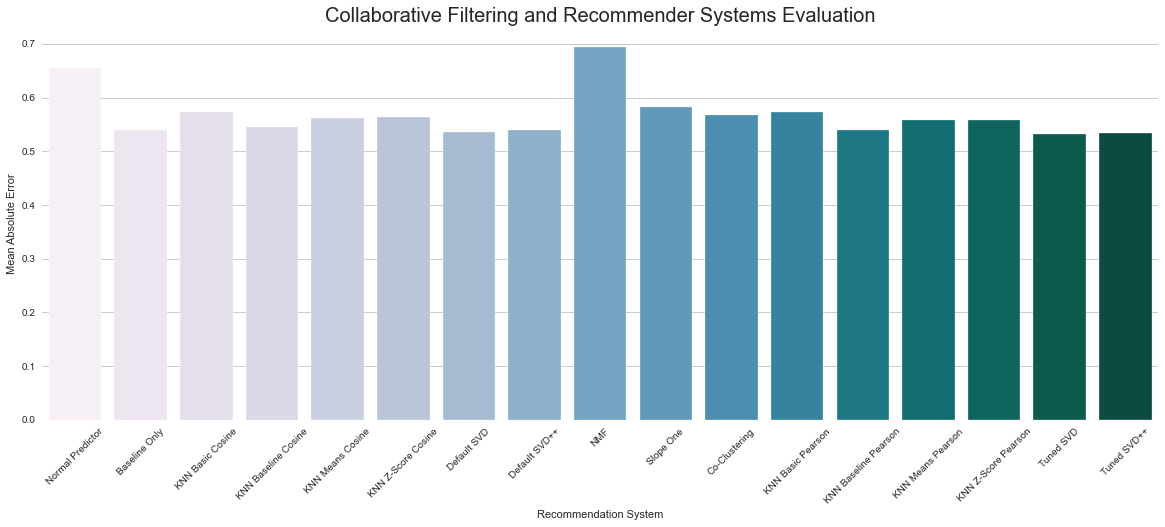

In [47]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,8))
plt.subplots_adjust(bottom=0.2)

sns.barplot(all_systems.index, all_systems['mae'], palette='PuBuGn') 
ax.set(xlim=[-0.5,16.5], xlabel='Recommendation System', ylabel='Mean Absolute Error')
ax.set_title('Collaborative Filtering and Recommender Systems Evaluation', fontsize=20)

labels = ['Normal Predictor', 'Baseline Only', 'KNN Basic Cosine', 'KNN Baseline Cosine', 'KNN Means Cosine', 
          'KNN Z-Score Cosine', 'Default SVD', 'Default SVD++', 'NMF', 'Slope One', 'Co-Clustering', 'KNN Basic Pearson', 
          'KNN Baseline Pearson', 'KNN Means Pearson', 'KNN Z-Score Pearson', 'Tuned SVD', 'Tuned SVD++']

plt.xticks(all_systems.index, labels, rotation=45)

plt.savefig('data/images/fig11.png', dpi=200, transparent=True)
plt.show()

#### Recommender Engine:

In [48]:
def svd_recommendation(user_id, n=10):
    '''
    Write here.
    '''
    unique_ids = df['itemID'].unique()
    item_user_id = df.loc[df['userID']==user_id, 'itemID']
    items_to_predict = np.setdiff1d(unique_ids, item_user_id)
    
    engine = SVD(n_factors=10, n_epochs=20, lr_all=0.01, reg_all=0.02)
    engine.fit(read_data.build_full_trainset())

    svd_recommendations = []
    for i in items_to_predict:
        svd_recommendations.append((i, engine.predict(uid=user_id, iid=i).est))

    display(user_data.loc[user_data['user_id']==user_id])
    print(f'----------------------------------------\nTop {n} Recommendations for User #{user_id}:')
    
    svd_recommendations = pd.DataFrame(svd_recommendations, columns=['item_id', 'predicted_rating'])
    svd_recommendations = svd_recommendations.sort_values('predicted_rating', ascending=False).head(n)
    svd_recommendations = svd_recommendations.merge(item_data, on='item_id')
    
    return svd_recommendations

In [49]:
sample = user_data.sort_values('rating_count', ascending=False)
sample.loc[((user_data['bust_size']=='32a') & (user_data['height']==62))].head(5)

,user_id,bust_size,rating_count,weight,rating_average,rented_for_top,body_type,category_top,height,size,age,review_length_average,review_month_top,review_season_top,rented_for_all,category_all
52769,501485,32a,42,105.00,4.98,party,petite,dress,62.00,4,27.00,33.62,4,Spring,"[other, work, formal affair, vacation, everyda...","[maxi, shirtdress, jumpsuit, gown, romper, she..."
76995,731517,32a,17,113.00,5.00,party,petite,dress,62.00,1,25.00,59.12,9,Summer,"[date, work, formal affair, everyday, party]","[maxi, gown, jacket, down, sheath, dress, top,..."
89653,849603,32a,17,100.00,5.00,everyday,petite,dress,62.00,1,27.00,91.88,6,Summer,"[other, wedding, work, formal affair, everyday...","[sweater, pants, gown, shift, dress, top]"
15262,145029,32a,16,115.00,4.50,everyday,petite,dress,62.00,4,43.00,14.19,8,Summer,"[other, vacation, everyday, work]","[maxi, jumpsuit, dress, romper, culottes, top,..."
50530,480611,32a,12,125.00,4.58,party,petite,dress,62.00,1,35.00,80.00,4,Fall,"[wedding, party]","[dress, sheath, skirt]"


In [50]:
svd_recommendation(480611)

,user_id,bust_size,rating_count,weight,rating_average,rented_for_top,body_type,category_top,height,size,age,review_length_average,review_month_top,review_season_top,rented_for_all,category_all
50530,480611,32a,12,125.00,4.58,party,petite,dress,62.00,1,35.00,80.00,4,Fall,"[wedding, party]","[dress, sheath, skirt]"


----------------------------------------
Top 10 Recommendations for User #480611:


,item_id,predicted_rating,fit_small,fit,fit_large,user_count,bust_size_top,weight_mean,weight_median,rating_average,rented_for_top,rented_for_all,body_type_top,category_top,height_mean,height_median,size_mean,size_median,age_mean,age_median,review_length_average,review_month_top,review_season_top
0,1215281,4.92,4.00,62.00,5.00,71,34d,131.76,130.00,4.96,wedding,"[wedding, other, party, formal affair]",athletic,gown,64.94,65.00,10.04,8.00,32.86,32.00,55.45,10,Fall
1,1451390,4.92,0.00,27.00,2.00,29,34b,136.59,135.00,4.97,wedding,"[wedding, work, formal affair, everyday, party]",hourglass,maxi,66.21,66.00,13.79,12.00,34.83,35.00,62.72,7,Summer
2,1186923,4.89,9.00,91.00,3.00,103,34c,137.48,135.00,4.92,party,"[other, date, wedding, formal affair, vacation...",hourglass,dress,65.33,65.00,13.53,14.00,30.33,30.00,65.70,11,Winter
3,1328898,4.88,1.00,42.00,1.00,44,34b,135.75,135.00,4.91,formal affair,"[wedding, other, formal affair]",hourglass,gown,66.05,66.00,9.61,8.00,33.82,32.00,63.27,10,Winter
4,1200223,4.88,3.00,37.00,2.00,42,34c,142.93,140.00,4.90,wedding,"[other, wedding, date, work, formal affair, ev...",hourglass,sheath,65.79,66.00,15.90,16.00,43.17,41.50,51.55,11,Winter
5,1003076,4.87,5.00,122.00,5.00,132,34b,137.98,135.00,4.89,wedding,"[other, wedding, date, formal affair, vacation...",athletic,dress,65.96,66.00,11.55,12.00,32.80,32.00,55.21,10,Winter
6,1547051,4.87,1.00,44.00,3.00,48,34c,137.29,135.00,4.92,wedding,"[wedding, other, party, formal affair]",hourglass,gown,65.27,65.00,11.69,12.00,34.08,32.00,55.90,11,Spring
7,2546911,4.86,1.00,28.00,0.00,29,34c,130.79,130.00,4.93,everyday,"[date, wedding, work, vacation, everyday, party]",hourglass,pant,64.83,65.00,9.45,8.00,35.07,35.00,35.79,10,Summer
8,740349,4.86,1.00,21.00,7.00,29,34b,136.21,135.00,4.86,wedding,"[other, wedding, date, work, formal affair, va...",hourglass,shift,65.10,65.00,12.76,12.00,35.69,35.00,41.03,5,Spring
9,1353811,4.86,8.00,25.00,4.00,37,34c,139.14,138.00,4.89,wedding,"[wedding, other, party, formal affair]",hourglass,dress,64.86,64.00,13.51,16.00,36.35,34.00,73.70,10,Fall


## VI. Further Research

Write here.

# Contact

Feel free to contact me for any questions and connect with me on [Linkedin](https://www.linkedin.com/in/czarinagluna/).